# AI News Tracker
For each RSS link: scrape → summarize → evaluate. Collect passing summaries, then write final report.

In [1]:
from typing import Annotated, TypedDict, List, Optional, Any, Dict
from enum import Enum

import feedparser
import nest_asyncio
from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import Tool

import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content

nest_asyncio.apply()
load_dotenv(override=True)

True

## Sources

In [2]:
SOURCE_CONFIG: dict[str, list[str]] = {
    "OpenAI": [
        "https://openai.com/news/rss.xml",
    ],
}


# Email Recipients

In [3]:

EMAIL_RECIPIENTS: List[str] = [
    "mohnish.unity3d.dev@gmail.com",
    "h33t92@gmail.com"
]

## Data Models

In [4]:
import operator


class ArticleSummary(BaseModel):
    title: str      = Field(description="The headline or title of the news article")
    source_url: str = Field(description="The original URL of the article")
    summary: str    = Field(description="A concise summary of the article in 3 to 5 concise bullet points")


class TrackerState(TypedDict):
    source_name: str
    feed_urls:   List[str]

    # Feed fetcher output
    raw_links:   List[str]

    # Per-link processing queue
    pending_links:   List[str]
    current_url:     Optional[str]

    # Accumulated results
    summaries:       Annotated[List[ArticleSummary], operator.add]
    current_text: str

    # Final output
    final_report:    Optional[str]

class EmailOutput(BaseModel):
    subject: str
    """The subject line for the email. """

    html_body: str
    """Nicely formatted HTML body for the email. """

## Prompts

In [5]:
SCRAPER_SYSTEM_PROMPT = """Get the content of the URL from the tools you are provided. No summarizing — just extract the text. """

EVALUATOR_SYSTEM_PROMPT = """You are a quality gate for a technical news pipeline.

The team is senior Python engineers on GCP using the OpenAI Assistants API, Chat Completions API, and openai-python SDK for RAG pipelines, multi-agent orchestration, function calling, and structured outputs.

Hard discard: DALL-E, Sora, ChatGPT consumer app, mobile SDKs, pricing changes, enterprise sales.

For each update: discard if it matches an irrelevance signal, doesn't relate to the team's stack, or lacks specific technical detail.

Mark is_sufficient=True only if 3+ HIGH/MEDIUM updates remain and every summary contains a specific technical detail (param, endpoint, version, or date). If not, provide a precise insufficiency_reason and 2-3 targeted suggested_search_queries."""


SUMMARIZER_SYSTEM_PROMPT = """You are summarizing an update for a senior Python team on GCP.
Skip anything about: pricing changes, enterprise sales, marketing content.

Given the page content, return cleanly written markdown:
- exact title of the update (should be a heading).
- Next line should be the exact source URL you were provided inside square brackets '[]'. For example if the url was https://dasd.com then the link should be presented as [https://dasd.com] in the next line.
- summary: 3 sentences — (1) what changed, (2) team impact, (3) action needed. Must include a specific technical detail. should be in bullet points. should be in markdown.

Make sure there is no other accompanying text other than the ones mentioned above."""

EMAIL_SYSTEM_PROMPT = """
Given a markdown report, You are able to come up with a succinct, to the point subject line and a nice formatted HTML body for the report to be meant to send emails.
"""

## Tools & LLMs

In [6]:
async_browser     = create_async_playwright_browser(headless=False)
playwright_toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
playwright_tools  = playwright_toolkit.get_tools()

tool_dict = {tool.name:tool for tool in playwright_tools}
for tool in playwright_tools:
    print(f"{tool.name}={tool}")

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

summarizer_agent = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def send_email(subject: str, html_body: str) -> bool:
    """ Send out an email with the given subject and HTML body. """
    try:
        sg = sendgrid.SendGridAPIClient(api_key=os.getenv("SENDGRID_API_KEY"))
        from_email = Email("mani.gamed3v@gmail.com")
        to_emails = [To(email) for email in EMAIL_RECIPIENTS]
        content = Content("text/html", html_body)
        mail = Mail(from_email, to_emails, subject, content).get()
        sg.client.mail.send.post(request_body=mail)
        return True
    except Exception as e:
        print(f"error: {e}")
        return False

# tool_email = Tool(
#     name="email",
#     func=send_email,
#     description="Useful for when you need to send an email with a provided subject line and HTML body.",
# )

email_agent = ChatOpenAI(model="gpt-4o-mini", temperature=0)
email_agent_with_output = email_agent.with_structured_output(EmailOutput)

# llm.bind_tools(playwright_tools)

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\h33t9\AppData\Local\ms-playwright\chromium-1208\chrome-win64\chrome.exe> version=145.0.7632.6>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\h33t9\AppData\Local\ms-playwright\chromium-1208\chrome-win64\chrome.exe> version=145.0.7632.6>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\h33t9\AppData\Local\ms-playwright\chromium-1208\chrome-win64\chrome.exe> version=145.0.7632.6>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\h33t9\AppData\Local\ms-playwright\chromium-1208\chrome-win64\chrome.exe> version=145.0.7632.6>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\h33t9\AppData\Local\ms-playwright\chromium-1208\chrome-win64\chrome.exe> version=145.0.7632.6>
get_elements=async_browser=<Browser type=<Bro

## Graph Nodes

In [7]:
import json as _json
from datetime import datetime, timedelta, timezone
from pathlib import Path
from IPython.display import Markdown, display

def get_last_run_date() -> datetime:
    cache_path = Path(".cached/cache.json")
    try:
        with cache_path.open("r", encoding="utf-8") as f:
            data = json.load(f)
        return datetime.fromisoformat(data["last_run"])
    except Exception:
        # Fallback: treat as last run was 5 days ago
        return datetime.now(timezone.utc) - timedelta(days=10)

def feed_fetcher_node(state: TrackerState) -> dict:
    print("[FEED FETCHER]: Starting ...")
    links: List[str] = []
    cutoff = get_last_run_date()

    for url in state["feed_urls"]:
        feed = feedparser.parse(url)

        for entry in feed.entries:
            if not hasattr(entry, "link"):
                continue

            # Prefer published_parsed, fallback to updated_parsed
            parsed_time = (
                getattr(entry, "published_parsed", None)
                or getattr(entry, "updated_parsed", None)
            )

            if not parsed_time:
                continue

            published = datetime(
                *parsed_time[:6],
                tzinfo=timezone.utc
            )

            if published > cutoff:
                links.append(entry.link)

    deduped = list(dict.fromkeys(links))
    print("[FEED FETCHER] Done.")
    return {
        "raw_links": deduped,
        "pending_links": deduped,
        "summaries": []
    }


def pick_next_link_node(state: TrackerState) -> dict:
    pending = list(state["pending_links"])

    if not pending:
        # Nothing left to process
        return {
            "current_url": None,
            "pending_links": []
        }

    return {
        "current_url": pending.pop(0),
        "pending_links": pending
    }

# def evaluator_node(state: TrackerState) -> TrackerState:


async def summarizer_node(state: TrackerState) -> dict:
    url = state["current_url"]

    if url is None:
        # Nothing to process
        return {}

    # Scrape
    try:
        print(f"[SUMMARIZER]: scraping {url}...")
        await navigate_tool.arun({"url": url})
        page_text = await extract_text_tool.arun({})
    except Exception as e:
        print(f"could not load page {url}: {e}");
        return {"summaries": []}

    # Summarize + evaluate in one call
    messages = [
        SystemMessage(content=SUMMARIZER_SYSTEM_PROMPT),
        # HumanMessage(content=f"URL: {url}\n\nPage content:\n{page_text}"),
        HumanMessage(content=f"URL: {url}\n\nText To Summarize: {page_text}"),
    ]

    summary = await summarizer_agent.ainvoke(messages)
    print("[SUMMARIZER]: Done.")
    return {"summaries": [summary.content]}


def writer_node(state: TrackerState) -> dict:
    print("[WRITER]: Writing Report ...")
    summaries = state["summaries"]

    if not summaries:
        print("No Updates available")
        return {}


    heading = f"# {state["source_name"]} UPDATES\n\n"
    body = "\n\n".join(summaries)
    final_report = heading + body
    print("[WRITER]: Report Done.")

    return {"final_report": final_report}

async def email_node(state: TrackerState):
    print("[EMAIL]: Sending Emails ...")
    if not state["final_report"]:
        print("[EMAIL]: Couldn't send emails. No Final_Report available.")
        return {"success": "no final report available."}
    messages = [
        SystemMessage(content=EMAIL_SYSTEM_PROMPT),
        # HumanMessage(content=f"URL: {url}\n\nPage content:\n{page_text}"),
        HumanMessage(content=f"Report: {state["final_report"]}"),
    ]
    email_output = await email_agent_with_output.ainvoke(messages)
    send_email(email_output.subject, email_output.html_body);
    print("[EMAIL]: Emails Sent.")
    return {"success": "ok"}

def has_pending_links(state: TrackerState) -> str:
    return "pick_next" if state["pending_links"] else "writer"

## Build Graph

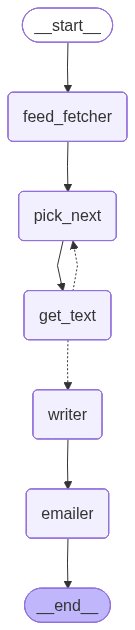

In [8]:
builder = StateGraph(TrackerState)

builder.add_node("feed_fetcher",         feed_fetcher_node)

builder.add_node("pick_next",            pick_next_link_node)
builder.add_node("get_text",             summarizer_node)
builder.add_node("writer",               writer_node)
builder.add_node("emailer",              email_node)

builder.add_edge(START,                  "feed_fetcher")
builder.add_edge("feed_fetcher",         "pick_next")
builder.add_edge("pick_next",            "get_text")
builder.add_conditional_edges("get_text", has_pending_links, {"pick_next": "pick_next", "writer": "writer"})
builder.add_edge("writer",               "emailer")
builder.add_edge("emailer",              END)

# graph = builder.compile(checkpointer=MemorySaver())
graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Run

In [9]:
import uuid


async def run_tracker(source_name: str) -> str:
    assert source_name in SOURCE_CONFIG, f"Unknown source: {source_name}"
    initial_state: TrackerState = {
        "source_name":   source_name,
        "feed_urls":     SOURCE_CONFIG[source_name],
        "raw_links":     [],
        "pending_links": [],
        "current_url":   None,
        "summaries":     [],
        "final_report":  None,
        "email_recipients": ["mohnish.unity3d.dev@gmail.com", "h33t92@gmail.com"]
    }
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    result = await graph.ainvoke(initial_state, config=config)
    return result

state = await run_tracker("OpenAI")

# import json
# pretty = json.dumps(report, indent=2, sort_keys=True)
# print(pretty)

# print(report)

[FEED FETCHER]: Starting ...
[FEED FETCHER] Done.
[SUMMARIZER]: scraping https://openai.com/index/openai-for-india...
[SUMMARIZER]: Done.
[SUMMARIZER]: scraping https://openai.com/index/new-result-theoretical-physics...
[SUMMARIZER]: Done.
[SUMMARIZER]: scraping https://openai.com/index/introducing-lockdown-mode-and-elevated-risk-labels-in-chatgpt...
[SUMMARIZER]: Done.
[SUMMARIZER]: scraping https://openai.com/index/scaling-social-science-research...
[SUMMARIZER]: Done.
[SUMMARIZER]: scraping https://openai.com/index/beyond-rate-limits...
[SUMMARIZER]: Done.
[SUMMARIZER]: scraping https://openai.com/index/introducing-gpt-5-3-codex-spark...
[SUMMARIZER]: Done.
[SUMMARIZER]: scraping https://openai.com/index/harness-engineering...
[SUMMARIZER]: Done.
[WRITER]: Writing Report ...
[WRITER]: Report Done.
[EMAIL]: Sending Emails ...


d:\Upwork\Systasa\tech-news-tracker\.venv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EmailOutput(subject='Late.../ul>\n</body>\n</html>'), input_type=EmailOutput])
  return self.__pydantic_serializer__.to_python(


[EMAIL]: Emails Sent.


# Write Back to Cache

In [10]:

display(Markdown(state["final_report"]))

import json

cache_dir = Path(".cached")
cache_dir.mkdir(exist_ok=True)

cache_file = cache_dir / "cache.json"
data = { "last_run": datetime.now(timezone.utc).isoformat() }

with cache_file.open("w", encoding="utf-8") as f:
    json.dump(data, f, indent=2)

# OpenAI UPDATES

# Introducing OpenAI for India

[https://openai.com/index/openai-for-india]

- OpenAI has launched a nationwide initiative, OpenAI for India, in collaboration with Tata Group to enhance AI access and capabilities in India, including the establishment of local AI-ready data centers with an initial capacity of 100 megawatts. 
- This initiative will significantly impact the team by facilitating the deployment of ChatGPT Enterprise across Tata Group's workforce, potentially involving hundreds of thousands of employees, and standardizing AI-native software development using OpenAI’s Codex. 
- Teams are encouraged to prepare for the integration of these advanced AI capabilities and to engage with local educational institutions to support the upskilling of professionals through OpenAI Certifications.

# GPT-5.2 derives a new result in theoretical physics | OpenAI

[https://openai.com/index/new-result-theoretical-physics]

- GPT-5.2 has proposed a new formula for a gluon amplitude that was previously thought to be zero under standard conditions, specifically in the half-collinear regime where gluon momenta are aligned in a special way. 
- This advancement impacts the team by providing a new methodology for computing scattering amplitudes, which could lead to further research and insights in particle physics, including extensions to graviton amplitudes. 
- Team members should review the preprint titled “Single-minus gluon tree amplitudes are nonzero” and consider how the findings might influence ongoing projects or inspire new research directions.

# Introducing Lockdown Mode and Elevated Risk labels in ChatGPT

[https://openai.com/index/introducing-lockdown-mode-and-elevated-risk-labels-in-chatgpt]

- Lockdown Mode and Elevated Risk labels have been introduced to enhance security against prompt injection attacks in ChatGPT, providing advanced protection for high-risk users. 
- The team will need to implement Lockdown Mode for users requiring increased security, which restricts web browsing to cached content only, preventing live network requests. 
- Admins should enable Lockdown Mode in Workspace Settings and familiarize themselves with the new "Elevated Risk" labels to guide users on potential risks associated with certain capabilities.

# Scaling social science research

[https://openai.com/index/scaling-social-science-research]

- A new open-source toolkit named GABRIEL has been released, which utilizes GPT to convert unstructured text and images into quantitative measurements for social science research. 
- This tool will significantly impact the team by allowing researchers to analyze qualitative data at scale, reducing the time spent on repetitive data labeling and enabling them to focus on more complex analysis. 
- Teams should explore the GABRIEL Python library and its tutorial notebook to integrate this tool into their research workflows, particularly for tasks like analyzing large collections of scientific papers or customer reviews.

# Beyond rate limits: scaling access to Codex and Sora

[https://openai.com/index/beyond-rate-limits]

- A new real-time access engine has been implemented for Codex and Sora, allowing users to purchase credits when they exceed rate limits, enabling continuous usage without interruptions. 
- This change impacts the team by requiring integration of a distributed usage and balance system that tracks per-user, per-feature usage and maintains real-time credit balances. 
- Teams should familiarize themselves with the new architecture that ensures real-time decision-making on usage limits and credit consumption, as it will affect how they manage user access and billing processes.

# Introducing GPT-5.3-Codex-Spark

[https://openai.com/index/introducing-gpt-5-3-codex-spark]

- A new model, GPT-5.3-Codex-Spark, has been released as a research preview, optimized for real-time coding with a performance of over 1000 tokens per second and a 128k context window.
- This update allows the team to experiment with ultra-fast coding capabilities and gather feedback from developers, enhancing the overall user experience in coding tasks.
- Developers should begin testing Codex-Spark in the Codex app, CLI, and VS Code extension, while being aware of its separate rate limits during the research preview.

# Harness engineering: leveraging Codex in an agent-first world

[https://openai.com/index/harness-engineering]

- The team has successfully built and shipped a software product with zero lines of manually-written code, relying entirely on Codex for all aspects of development, resulting in a million lines of code generated in about one-tenth the time it would have taken manually. 
- This shift redefines the role of engineers to focus on designing environments and enabling agents, with a significant increase in throughput observed as the team expanded from three to seven engineers, averaging 3.5 pull requests per engineer per day. 
- Teams should continue to refine the context management and documentation practices to ensure Codex can effectively navigate and execute tasks, as well as implement the "golden principles" for maintaining code quality and coherence.